In [64]:
from qick import *
%pylab inline

import time

from scipy.signal import welch
from numpy.fft import fftshift

from scipy.signal import spectrogram
from matplotlib import colors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/Daniel/qick/.qick_venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['psd']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [65]:
# Pyro to communicate with board
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
# print(soccfg)

In [66]:
GEN_CH_A = 1
GEN_CH_B = 0
RO_CH_C = 1
RO_CH_D = 0
FREQ = 500 # MHz

In [67]:
# Class containg init method to process pulse sequences for each channel
class DigitalOutput():
    sequence = []

    def __init__(self, pmod_ch, seq):
        self.pmod_ch = pmod_ch
        self.seq = seq

        # Remove pre-exisiting sequence if it already exists for channel
        for l in self.sequence[:]:
            if l[-1] == self.pmod_ch:
                self.sequence.remove(l)
        
        if self.seq != None:
            # Convert list of tuples into list of lists
            self.seq = [list(t) for t in self.seq]

            # Convert pulse widths into elapsed time and append channel to list
            time = 0
            for l in self.seq:
                l[0], time = time, time + l[0]
                l.append(pmod_ch)
            
            # End final pulse
            self.seq.append([time, 0, pmod_ch])

            # Add channel sequence to master sequence and sort in order of time
            [self.sequence.append(l) for l in self.seq]
            self.sequence.sort(key=lambda x: x[0])
        
    def configure(self):
        out = 0
        # trig_output = self.soccfg['tprocs'][0]['trig_output']
        for l in DigitalOutput.sequence: 
            time = int(self.us2cycles(l[0]) / 1e3)
            state = l[1]
            bit_position = l[2]

            if state == 1:
                out |= (1 << bit_position)
            elif state == 0:
                out &= ~(1 << bit_position)

            rp = 0 # tproc register page
            r_out = 31 # tproc register
            print(bin(out), time)
            self.regwi(rp, r_out, out)
            self.seti(soccfg['tprocs'][0]['output_pins'][0][1], rp, r_out, time)

In [68]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        style = self.cfg["pulse_style"]

        self.declare_gen(ch=GEN_CH_A, nqz=1)
        self.declare_gen(ch=GEN_CH_B, nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            # self.declare_readout(ch=ch, length=self.cfg["readout_length"],
            #                      freq=0, gen_ch=cfg["res_ch"], sel="input")
            self.declare_readout(ch=ch, length=self.cfg["readout_length"], freq=0, sel="input")

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=GEN_CH_A, freq=freq, phase=phase, gain=gain)
        self.default_pulse_registers(ch=GEN_CH_B, freq=freq, phase=phase, gain=gain)

        idata_a, qdata_a = [], []
        for i in range(96):
            x_vals = np.linspace(0, 2 * np.pi, 100)
            sinusoid = 10000 * np.sin(x_vals)
            idata_a.extend(sinusoid)
            qdata_a.extend(sinusoid)
        self.add_envelope(ch=GEN_CH_A, name="measure_a", idata=idata_a, qdata=qdata_a)
        self.set_pulse_registers(ch=GEN_CH_A, style=style, waveform="measure_a", outsel="input")

        idata_b, qdata_b = [], []
        for i in range(96):
            # x_vals = np.linspace(0, 2 * np.pi, i * 10 + 100)
            x_vals = np.linspace(0, 2 * np.pi, 20)
            sinusoid = 10000 * np.sin(x_vals)
            idata_b.extend(sinusoid)
            qdata_b.extend(sinusoid)
        self.add_envelope(ch=GEN_CH_B, name="measure_b", idata=idata_b, qdata=qdata_b)
        self.set_pulse_registers(ch=GEN_CH_B, style=style, waveform="measure_b", outsel="input")

        # self.add_envelope(ch=GEN_CH_A, name="measure_a", idata=idata_b, qdata=qdata_b)
        # self.set_pulse_registers(ch=GEN_CH_A, style=style, waveform="measure_a", outsel="input")
        
        self.synci(100)  # give processor some time to configure pulses
        self.trigger(mr=True, adc_trig_offset=self.cfg["adc_trig_offset"])
        self.synci(100)  # give the buffers a little time
        
    def body(self):
        self.trigger(adcs=self.ro_chs,
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.pulse(ch=GEN_CH_B)
        self.pulse(ch=GEN_CH_A)

        seq_0 = DigitalOutput(0, [(100, 0), (27000, 1), (100.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (450.0, 0), (100.0, 1), (450.0, 0), (3000.0, 0), (100.0, 0)])
        seq_1 = DigitalOutput(1, [(100.0, 0), (27000, 1), (100.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (1000.0, 0), (3000.0, 1), (100.0, 0)])

        DigitalOutput.configure(self)

        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [70]:
config={"res_ch":GEN_CH_A,
        "ro_chs":[RO_CH_C, RO_CH_D],
        "reps":1,
        "relax_delay":1.0, # [us]
        "res_phase":0, # [degrees]
        "pulse_style": "arb",
        "length":500, # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": FREQ, # [MHz]
        "adc_trig_offset": 0, # [Clock ticks]
        "soft_avgs":1
       }

prog =LoopbackProgram(soccfg, config)
prog.config_all(soc)
soc.arm_mr(ch=RO_CH_D)
# n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
# soc.arm_ddr4(ch=RO_CH_C, nt=n_transfers)
iq_list = prog.acquire_decimated(soc, progress=True)

0b0 0
0b0 0
0b1 40
0b11 40
0b10 11100
0b0 11100
0b0 11141
0b10 11141
0b10 12369
0b0 12369
0b1 12554
0b0 12595
0b0 12779
0b10 12779
0b10 14008
0b0 14008
0b1 14192
0b0 14233
0b0 14417
0b10 14417
0b10 15646
0b0 15646
0b1 15831
0b0 15872
0b0 16056
0b10 16056
0b10 17285
0b0 17285
0b1 17469
0b0 17510
0b0 17694
0b10 17694
0b10 18923
0b0 18923
0b1 19107
0b0 19148
0b0 19333
0b10 19333
0b10 20561
0b0 20561
0b1 20746
0b0 20787
0b0 20971
0b10 20971
0b10 22200
0b0 22200
0b0 22241
0b0 22241


ConnectionClosedError: receiving: connection lost: [Errno 54] Connection reset by peer

In [ ]:
# iq_mr = soc.get_mr()
# # iq_ddr4 = soc.get_ddr4(6)
# for ii, iq in enumerate(iq_list):
#     plt.plot(iq[0][:], label="I value, ADC %d"%(config['ro_chs'][ii]))
#     # plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
#     # plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
# # plt.plot(iq_mr[850:950,0])
# plt.xlabel("sample number [ADC ticks]")
# plt.legend();

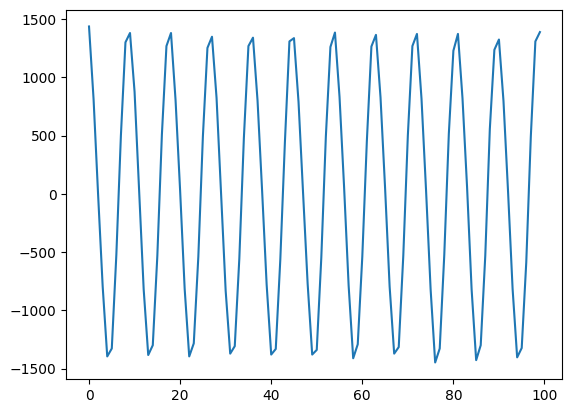

In [ ]:
iq_mr = soc.get_mr()
plt.plot(iq_mr[2000:2100,0]);

Frequency: 492.48 MHz


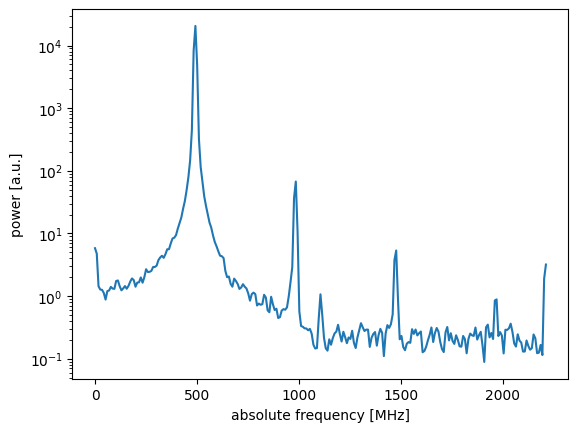

In [ ]:
complex_iq = iq_mr.dot([1,1j])
fs_adc = soccfg['readouts'][RO_CH_C]['fs']
fft_freqs, psd = welch(iq_mr[850:4000,0], fs_adc, return_onesided=True, detrend=False, nperseg=512)
plt.semilogy(fft_freqs, psd)
plt.xlabel("absolute frequency [MHz]")
plt.ylabel("power [a.u.]");
print("Frequency:", fft_freqs[argmax(psd)], "MHz")